# Web Scraping & Predicting

In this project, we will practice two major skills. Collecting data by scraping a website and building a binary predictor with Logistic Regression.

### Step 1: Scrape your site

We will be scraping your website using BeautifulSoup. Write your code below.

In [696]:
from bs4 import BeautifulSoup as Soup
import urllib, requests, re, pandas as pd
import urllib2

import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.cross_validation import cross_val_score, train_test_split

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
## Getting list of job details from Indeed.com 

pd.set_option('max_colwidth',500)
jobs = pd.DataFrame()

# print soup
for page in range(1,75):
    page = (page-1) *10
    soup = BeautifulSoup(urllib2.urlopen
                         ('http://www.indeed.com/jobs?q=software&l=Seattle%2C+WA&start='+ str(page)).read(), "lxml")

    target = soup.findAll('div', attrs ={"class" : " row result"})

    for elem in target: 
        home_url = "http://www.indeed.com"
        job_link = "%s%s" % (home_url,elem.find('a').get('href'))
        job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
        job_posted = elem.find('span', attrs={'class': 'date'}).getText()
        job_addr = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()       
        
        try:
            data = ''
            s = BeautifulSoup(urllib2.urlopen(job_link).read(), "lxml")
            for x in s.find_all(['p','ul']):
                data = data + ' ' + x.text

        except Exception as e:
            data = 'error'

        jobs = jobs.append({'title': job_title,
                            'url': job_link,
                            'posted': job_posted,
                            'location': job_addr,
                            'body' : data
                           }, ignore_index=True)

In [403]:
## Data Science Jobs from Indeed.com

pd.set_option('max_colwidth',500)    # to remove column limit (Otherwise, we'll lose some info)
ds = pd.DataFrame()

# print soup
for page in range(1,75):
    page = (page-1) *10
    soup = BeautifulSoup(urllib2.urlopen('http://www.indeed.com/jobs?q=data+science&l=Seattle,+WA&start='+ str(page)).read(), "lxml")

    target = soup.findAll('div', attrs ={"class" : " row result"})

    for elem in target: 
        home_url = "http://www.indeed.com"
        job_link = "%s%s" % (home_url,elem.find('a').get('href'))
        job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
        job_posted = elem.find('span', attrs={'class': 'date'}).getText()
        job_addr = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()       
        
        try:
            data = ''
            s = BeautifulSoup(urllib2.urlopen(job_link).read(), "lxml")
            for x in s.find_all(['p','ul']):
                data = data + ' ' + x.text

        except Exception as e:
            data = 'error'

        
        ds = ds.append({'title': job_title,
                        'url': job_link,
                       'posted': job_posted,
                        'location': job_addr,
                        'body' : data
                       }, ignore_index=True)

In [450]:
# taking backup of jobs dataframe
ndf = jobs
nds = ds

In [458]:
# Dataframe with all jobs
job_list = pd.concat([ndf, nds])
job_list = job_list.reset_index(drop = True)

In [468]:
len(job_list)
job_list.head()

2007

In [367]:
# Adding new column - class
job_list['class'] = 0

# Lower case Job title and Body
job_list.title.map(lambda x: x.lower())

for i in job_list.index.values:   
    job_list.body[i] = job_list.body[i].encode('ascii', 'ignore').lower()

In [408]:
# Classification based on keywords in TITLE column 
job_list['class'] = (job_list['title'].map(lambda x: x.lower()).str.contains('data ') | 
                     job_list['title'].map(lambda x: x.lower()).str.contains('machine learning'))

### Write functions to extract the features you think correlate well with your dataset. You MUST have at least 4 features!

- **Make sure these functions are robust and can handle cases where fields may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [720]:
# Feature Selection
job_list['is_dataScience'] = (job_list['body'].str.contains('data science') | 
                              job_list['body'].str.contains('data scientist'))
job_list['is_ml'] = job_list['body'].str.contains('machine learning')
job_list['is_python'] = job_list['body'].str.contains('python')
job_list['is_stat'] = (job_list['body'].str.contains('statistical') | 
                              job_list['body'].str.contains('statistics'))
job_list['is_cs'] = job_list['body'].str.contains('computer science')
job_list['is_visual'] = (job_list['body'].str.contains('tableau') | 
                         job_list['body'].str.contains('data visual'))

### Make sure you have at least 1000 rows before continuing.

#### Clean up / standardize your data here

- Dates converted to correct format
- Remove dollar signs, spaces, periods
- etc

In [710]:
len(job_list)

2007

### Create a dataframe to compile the results of your data cleaning.

In [717]:
## Dataframe without Column BODY
job_list.columns.values
job_list[['location', 'posted', 'title', 'url', 'class',
       'is_dataScience', 'is_ml', 'is_python', 'is_stat', 'is_cs',
       'is_visual']].head()

,location,posted,title,url,class,is_dataScience,is_ml,is_python,is_stat,is_cs,is_visual
0,"Bellevue, WA",3 days ago,Jr. Software Test Engineer,http://www.indeed.com/cmp/BrightStarr-US-Inc/jobs/Junior-Software-Test-Engineer-6180c776fdbec5cd?r=1&fccid=01418573e66f4b58,False,False,False,False,False,False,False
1,"Seattle, WA",3 days ago,UI Developer,http://www.indeed.com/cmp/SPK-CONSULTANTS/jobs/Ui-Developer-e08243b5ab787a6a?r=1&fccid=11f41208fd5ba2a0,False,False,False,False,False,False,False
2,"Redmond, WA 98052",1 day ago,Software Engineer,http://www.indeed.com/rc/clk?jk=1acd84066dc3b05b&fccid=734cb5a01ee60f80,False,False,False,False,False,False,False
3,"Redmond, WA",4 days ago,Software Engineering Intern,http://www.indeed.com/rc/clk?jk=a95f6ce1bad59b3a&fccid=50208b5bf45ee3b8,False,False,False,False,False,False,False
4,"Seattle, WA 98121 (Belltown area)",2 days ago,software Engineer- Internship- Junior,http://www.indeed.com/rc/clk?jk=9b902012834af545&fccid=aef928e89977f7f0,False,False,False,False,False,False,False


### Fill all the empty values with the column means or remove the rows from your table depending on your circumstances

In [614]:
## YOUR CODE HERE
# Not required

### Save your results as a CSV

In [718]:
## YOUR CODE HERE
job_list.to_csv('job_list.csv', sep=',', encoding ='utf-8')

## Prediction using Logistic Regression

#### Load in the the data of scraped

In [12]:
## YOUR CODE HERE
job_list = pd.DataFrame('job_list.csv')

### We want to predict whether the target was in a range or not with a binary variable. Create binary variables for some of your non-binary features, so we can draw correlations. See the logisitic regression lab if you are having trouble understanding the instructions. 

### Thought experiment: What is the baseline accuracy for this model?

In [555]:
## YOUR CODE HERE
a = len(job_list[job_list['class']])
b = len(job_list)

In [558]:
a *100/float(b)

15.894369706028899

### Create a Logistic Regression model to predict your target using statsmodel. Start by ONLY using one feature. Display the coefficients and write a short summary of what each feature means.

In [601]:
statdf = job_list.applymap(lambda x: 1 if x else 0)

In [609]:
statdf.rename(columns={'class':'label'}, inplace=True)

In [610]:
model = sm.logit(
    "label ~ is_dataScience",
    data = statdf
).fit() # We call fit to learn the coefficients of the model similar to linear regression model

model.summary()

Optimization terminated successfully.
         Current function value: 0.390926
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2007
Model:                          Logit   Df Residuals:                     2005
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Oct 2016   Pseudo R-squ.:                  0.1073
Time:                        14:23:06   Log-Likelihood:                -784.59
converged:                       True   LL-Null:                       -878.89
                                        LLR p-value:                 6.397e-43
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.9751      0.071    -27.885      0.000        -2.114    -1.836
is_dataScience     2.5456      0.187     13.584      0.000         2.178     2.913
==================================================================================
"""

## Stats Model with more variables

In [611]:
model = sm.logit(
    "label ~ is_dataScience + is_ml + is_python + is_stat + is_cs + is_visual",
    data = statdf
).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.367582
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 2007
Model:                          Logit   Df Residuals:                     2000
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 Oct 2016   Pseudo R-squ.:                  0.1606
Time:                        14:24:13   Log-Likelihood:                -737.74
converged:                       True   LL-Null:                       -878.89
                                        LLR p-value:                 5.027e-58
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.9572      0.080    -24.573      0.000        -2.113    -1.801
is_dataScience     1.6983      0.245      6.924      0.000         1.218     2.179
is_ml              1.4535      0.274      5.309      0.000         0.917     1.990
is_python          0.4734      0.233      2.034      0.042         0.017     0.930
is_stat            1.0837      0.238      4.560      0.000         0.618     1.550
is_cs             -0.9832      0.195     -5.044      0.000        -1.365    -0.601
is_visual          0.2377      0.377      0.631      0.528        -0.501     0.976
==================================================================================
"""

## Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!

In [559]:
def examine_coefficients(model, df):
    df = pd.DataFrame(
        { 'Coefficient' : model.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')
    return df[df.Coefficient !=0 ]

In [596]:
## YOUR CODE HERE
X = job_list[['is_dataScience']]
y = job_list['class']

logreg = LogisticRegression() 

logreg.fit(X, y)
print examine_coefficients(model, X)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

   Coefficient         Feature
0     2.450596  is_dataScience
mean accuracy: 0.860993017423, all: [ 0.83731343  0.89536622  0.8502994 ]
mean precision: 0.611574074074, all: [ 0.47222222  0.8         0.5625    ]
mean recall: 0.288808558161, all: [ 0.1588785   0.45283019  0.25471698]
mean roc_auc: 0.628999493246, all: [ 0.56256536  0.7157579   0.60867522]


#### Create a few new variables in your dataframe to represent interesting aspects of your features.
- For example, create a feature that represents whether 'Senior' is in the title when dealing with employment statistics
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [618]:
## Scikit model
X = job_list[['is_dataScience', 'is_ml', 'is_python','is_stat', 'is_cs', 'is_visual']]
y = job_list['class']


logreg = LogisticRegression() 

logreg.fit(X, y)
print examine_coefficients(logreg, X)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg, X, y, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

   Coefficient         Feature
4    -0.922385           is_cs
5     0.234724       is_visual
2     0.471030       is_python
3     1.056737         is_stat
1     1.376650           is_ml
0     1.625469  is_dataScience
mean accuracy: 0.868956202224, all: [ 0.86268657  0.88639761  0.85778443]
mean precision: 0.777895981087, all: [ 0.8         0.91666667  0.61702128]
mean recall: 0.257273849409, all: [ 0.18691589  0.31132075  0.27358491]
mean roc_auc: 0.68882915174, all: [ 0.63744792  0.77600623  0.6530333 ]


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [650]:
## Cross Validation 
X = job_list[['is_dataScience', 'is_ml', 'is_python','is_stat', 'is_cs', 'is_visual']]
y = job_list['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=77)

logreg_cv = LogisticRegressionCV()

logreg_cv.fit(X_train, Y_train)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg_cv, X_test, Y_test, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.86056129279, all: [ 0.85714286  0.86309524  0.86144578]
mean precision: 0.753968253968, all: [ 0.71428571  0.83333333  0.71428571]
mean recall: 0.187559354226, all: [ 0.18518519  0.18518519  0.19230769]
mean roc_auc: 0.634992605678, all: [ 0.57919622  0.7224849   0.6032967 ]


In [651]:
## Cross Validation 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=77)

logreg_cv = LogisticRegressionCV()
logreg_cv.fit(X_train, Y_train)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg_cv, X_test, Y_test, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.884457275924, all: [ 0.88690476  0.85628743  0.91017964]
mean precision: 0.744107744108, all: [ 0.77777778  0.45454545  1.        ]
mean recall: 0.285628019324, all: [ 0.29166667  0.2173913   0.34782609]
mean roc_auc: 0.706230290526, all: [ 0.69024884  0.68115942  0.74728261]


#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?
## Using GridSearchCV

In [670]:
## GridSearchCV to come with best paramaters
from sklearn.grid_search import GridSearchCV
X = job_list[['is_dataScience', 'is_ml', 'is_python','is_stat', 'is_cs', 'is_visual']]
y = job_list['class']

logreg = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='accuracy')
gs.fit(X, y)

/Users/Shreyas/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy',
       verbose=True)

In [708]:
## YOUR CODE HERE
gs.best_params_

{'C': 2.5, 'penalty': 'l1'}

In [725]:
## Model with BEST PARAMETERS
X = job_list[['is_dataScience', 'is_ml', 'is_python','is_stat', 'is_cs', 'is_visual']]
y = job_list['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=77)

logreg = LogisticRegression(C=2.5, penalty='l1')

logreg.fit(X_train, Y_train)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg_cv, X_test, Y_test, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.884457275924, all: [ 0.88690476  0.85628743  0.91017964]
mean precision: 0.744107744108, all: [ 0.77777778  0.45454545  1.        ]
mean recall: 0.285628019324, all: [ 0.29166667  0.2173913   0.34782609]
mean roc_auc: 0.716588248121, all: [ 0.69082755  0.68115942  0.77777778]


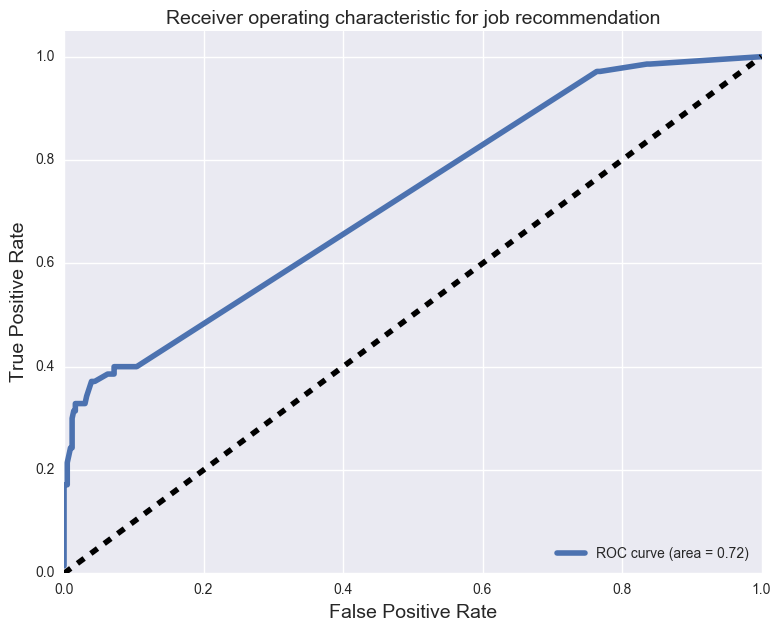

In [723]:
# ROC Curve
Y_proba_score = logreg.predict_proba(X_test)

FPR, TPR, thresholds = roc_curve(Y_test, Y_proba_score[:,1])

ROC_AUC = auc(FPR, TPR)

plt.figure(figsize=[9,7])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic for job recommendation', fontsize=14)
plt.legend(loc="lower right")
plt.show()

### The above model is the best MODEL with the amount of data munging and feature selection. The model could have been improved with more data analysis, cleaning the BODY column to retain the best keywords and by selecting right set of features


### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from text summaries if they exist. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

## Count Vectorizer for column BODY, selecting most common 200 words

In [689]:
## YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=200, # Only use the top 200 most common words
)

# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(job_list.body).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())

In [690]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=77)

logreg_cv = LogisticRegressionCV(Cs=15, cv=5, penalty='l2', scoring='accuracy', solver='liblinear')

logreg_cv.fit(X_train, Y_train)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg_cv, X_test, Y_test, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.83462421113, all: [ 0.83928571  0.83928571  0.8253012 ]
mean precision: 0.0666666666667, all: [ 0.   0.   0.2]
mean recall: 0.0128205128205, all: [ 0.          0.          0.03846154]
mean roc_auc: 0.614765467218, all: [ 0.51615445  0.57223536  0.75590659]


### The above Model has very low scores and is not the right model. Model is with the most common 200 words in body column, but it has lot of unwanted words.  More Data analsysis and munging is required to get the right set of common words as features

## Count Vectorizer with column TITLE with most common 50 words

In [693]:
## YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 200 most common words
)

# This builds a matrix with a row per website (or data point) and column per word (using all words in the dataset)
X = v.fit_transform(job_list.title).todense()
X = pd.DataFrame(X, columns=v.get_feature_names())

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [694]:
## YOUR CODE HERE

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=77)

logreg_cv = LogisticRegressionCV(Cs=15, cv=5, penalty='l2', scoring='accuracy', solver='liblinear')

logreg_cv.fit(X_train, Y_train)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(logreg_cv, X_test, Y_test, scoring=metric)
    print("mean {}: {}, all: {}".format(metric, scores.mean(), scores))

mean accuracy: 0.996031746032, all: [ 0.98809524  1.          1.        ]
mean precision: 0.977011494253, all: [ 0.93103448  1.          1.        ]
mean recall: 1.0, all: [ 1.  1.  1.]
mean roc_auc: 0.998861745907, all: [ 0.99658524  1.          1.        ]


### The above model looks like a very good fit, but the class label is taken from title column. This is not the RIGHT  model

## Problem Statement
### Recommendation System for people looking for data science jobs.

To suggest if the new job posting is data science job or not,
if a data science job is posted in Indeed.com, I should get a notification

